In [1]:
import catboost as cgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import pandas as pd
import numpy as np
import time
import gc
from joblib import Parallel, delayed

from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import seaborn as sns

feature_path = 'feature/'
model_path = 'model/'
submit_path = 'submit/'
#stacking feature data
metafeature_path = 'meta-feature/'
pic_path = 'pic/'
train_data_1_len = 1000000
train_data_2_len = 5000000
test_data_len = 1000000


def reduce_mem_usage(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = data.memory_usage().sum() / 1024**2    
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)    
    end_mem = data.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return data

def combine_feature_feather(feature_file_list=None):
    '''
    从feature文件夹中加载feature
    feature_file_list:默认加载feature_path下所有feature文件；可传入列表选择文件
    '''
    if feature_file_list != None and type(feature_file_list) != list:
        raise ValueError("Unable to load features from {0}".format(str(feature_file_list)))
    
    if feature_file_list == None:
        feature_file_list = os.listdir(feature_path)
    
    if len(feature_file_list) < 1:
        print('Empty feature file list')
        return None
    
    # 无法读取混合类型的文件
    # 请将feature_path目录下文件统一格式存储
    file_type_num = len(set([x.split('.') for x in feature_file_list]))
    if file_type_num > 1:
        raise ValueError("Unable to load features from mix type feature file : file type number-{0}".format(str(file_type_num)))
    
    #并行读取文件
    feature_df_list = []
    def df_append(file):
        feature_df_list.append(pd.read_feather(file))

    Parallel(n_jobs=-1)(delayed(df_append)(file_name) for file_name in feature_file_list)
    
    data = pd.concat(feature_df_list,axis=1).reset_index(drop=True)
    del feature_df_list
    gc.collect()
    return data


#计算F1score的函数,传入正确的结果和预测结果，返回F1_score
def cal_f1(true_valid,pred_valid):
    pred_valid = np.round(pred_valid)
    TP = np.sum(true_valid*pred_valid, axis=0)
    TN = np.sum((1-true_valid)*(1-(pred_valid)), axis=0)
    FP = np.sum((1-true_valid)*(pred_valid), axis=0)
    FN = np.sum(true_valid*(1-(pred_valid)), axis=0)
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision + recall)
    return F1

def lgb_f1(true_valid,pred_valid):
    return ('f1',cal_f1(true_valid,pred_valid),True)

def kfold_train(model,train_x,train_y,test,kfold=5):
    '''
    clf
    train_x:训练集特征，需去除sid和label
    train_y:训练集对应的label
    test:测试集特征，需去除sid和label(-1)
    '''
    f1s = []
    features = [col for col in train_x.columns if col not in ['sid', 'label']]
    train_pred = np.zeros(train_x.shape[0])
    test_pred = np.zeros(test.shape[0]) 
    skf=StratifiedKFold(n_splits=kfold,shuffle=True,random_state=2019)
    seed = [20190920,6666,1024,2048,4096]
    
    feature_importance_df = pd.DataFrame()
    
    for i,(train_fold,valid_fold) in enumerate(skf.split(train_x,train_y)):
        model.random_state = seed[i]
        if str(type(model)) == "<class 'lightgbm.sklearn.LGBMClassifier'>":
            model.fit(pd.DataFrame(np.array(train_x)[train_fold],columns=features),
                      train_y[train_fold],
                      eval_set = (pd.DataFrame(np.array(train_x)[valid_fold],columns=features),
                                  train_y[valid_fold]),eval_metric=lgb_f1,verbose=50)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = pd.Series(features)
            fold_importance_df["importance"] = pd.Series( model.feature_importances_ )
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
                                                         
        if str(type(model)) == "<class 'catboost.core.CatBoostClassifier'>":
            model.fit(pd.DataFrame(np.array(train_x)[train_fold],columns=features),
                      train_y[train_fold],
                      eval_set = (pd.DataFrame(np.array(train_x)[valid_fold],columns=features),
                                  train_y[valid_fold]),verbose=50)
        
        gc.collect()
        #sklearn的概率预测有两列，对应0和1；取第二列
        train_pred[valid_fold] += model.predict_proba(pd.DataFrame(np.array(train_x)[valid_fold],columns=features))[:,1]
        f1s.append(cal_f1(train_y[valid_fold],train_pred[valid_fold]))
        test_pred += model.predict_proba(test)[:,1]
    '''                                                    
    # 打印特征重要度
    cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features (averaged over folds)')
    plt.tight_layout()
    ''' 
    print('oof f1:',cal_f1(np.round(train_pred),train_y))
    print('oof mean f1:',np.mean(f1s))
    print('oof f1 std:',np.std(f1s))
    test_pred/=5
    return train_pred,test_pred

def train_once(model,train_x,train_y):
    features = [col for col in train_x.columns if col not in ['sid', 'label']] 
    seed = 20190920
    model.random_state = seed
    feature_importance_df = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=seed,shuffle=True)
    
    model.fit(pd.DataFrame(X_train,columns=features),
                      y_train,
                      eval_set = (pd.DataFrame(X_test,columns=features),y_test),
              eval_metric=lgb_f1,verbose=50)
    gc.collect()
    
    feature_importance_df["feature"] = pd.Series(features)
    feature_importance_df["importance"] = pd.Series( model.feature_importances_ )
    # 打印特征重要度
    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by="importance",ascending=False))
    plt.title('Features (averaged over folds)')
    plt.tight_layout()
    return True

In [2]:
%time data = pd.read_feather(feature_path+'screen_ft.bin', use_threads = 12)

Wall time: 759 ms


In [3]:
data.head()

,h,w,ppi,h_w_ratio,screen_area,size,orientation,creative_dpi,px
0,2340.0,1080.0,3.0,2.166667,2527200.0,1.014649,0,1699,3.043946
1,1080.0,2040.0,0.0,0.529412,2203200.0,0.908758,0,243,0.000000
2,2196.0,1080.0,0.0,2.033333,2371680.0,0.963467,1,1559,0.000000
3,0.0,0.0,0.0,NaN,0.0,0.000000,0,0,0.000000
4,2244.0,1080.0,0.0,2.077778,2423520.0,0.980460,0,1614,0.000000


In [2]:
%time data = pd.read_feather(feature_path+'combine.bin')
%time data = reduce_mem_usage(data)

cat_list = ['make', 'model', 'big_model', 'model_equal_make', 'ip',
       'ip1', 'reqrealip', 'ip2', 'ip3', 'reqrealip1', 'reqrealip2',
       'reqrealip3', 'ip_equal', 'adidmd5', 'imeimd5', 'macmd5',
       'adunitshowid', 'mediashowid', 'city', 'province','orientation', 'creative_dpi','dvctype', 'apptype', 'carrier', 'lan',
       'ntt', 'new_ntt', 'osv', 'osv_summary', 'ver', 'hour', 'minute',
       'period']
num_list = [col for col in data.columns if col not in cat_list + ['sid','label']]


#from sklearn.impute import SimpleImputer
#data = data.replace([np.inf,-np.inf],np.nan)
#imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent',copy=False)
#imp.fit_transform(data[cat_list])

#%time data = reduce_mem_usage(data)

train_x = data[:5000000]
train_y=train_x['label'].values
test=data[5000000:].reset_index(drop=True)
del data
gc.collect()

Wall time: 1min 4s
Mem. usage decreased to 1348.50 Mb (55.7% reduction)
Wall time: 12.8 s


7

In [4]:
data.get_label()

AttributeError: 'DataFrame' object has no attribute 'get_label'

In [5]:
cgb_model = CatBoostClassifier(iterations=5000,learning_rate=0.1,max_depth=8,
                                       task_type='GPU',eval_metric='F1',
                                       cat_features=cat_list,use_best_model=True, early_stopping_rounds=100,random_seed=20191024,
                                  boosting_type='Plain',max_bin=15,max_ctr_complexity=1)

lgb_model = lgb.LGBMClassifier(boosting_type='goss', num_leaves=127, 
                               max_depth=10, learning_rate=0.2, n_estimators=5000,
                              tree_learner='data',device_type='cpu',feature_fraction=1.0,
                              reg_alpha=2,reg_lambda=5,importance_type='gain',
                              early_stopping_round=100)

In [6]:
%time _,test_pred = kfold_train(cgb_model,train_x.drop(['sid','label'],axis=1),train_y,test.drop(['sid','label'],axis=1))

0:	learn: 0.9469598	test: 0.9490182	best: 0.9490182 (0)	total: 371ms	remaining: 30m 54s
50:	learn: 0.9649020	test: 0.9679622	best: 0.9679622 (50)	total: 15.2s	remaining: 24m 35s
100:	learn: 0.9672703	test: 0.9701030	best: 0.9701030 (100)	total: 36.3s	remaining: 29m 19s
150:	learn: 0.9683412	test: 0.9711195	best: 0.9711195 (150)	total: 1m 4s	remaining: 34m 35s
200:	learn: 0.9690007	test: 0.9718012	best: 0.9718012 (200)	total: 1m 32s	remaining: 36m 46s
250:	learn: 0.9694253	test: 0.9721664	best: 0.9721705 (247)	total: 1m 59s	remaining: 37m 49s
300:	learn: 0.9697234	test: 0.9724202	best: 0.9724202 (300)	total: 2m 27s	remaining: 38m 22s
350:	learn: 0.9699869	test: 0.9726643	best: 0.9726718 (349)	total: 2m 55s	remaining: 38m 42s
400:	learn: 0.9702123	test: 0.9728554	best: 0.9728554 (400)	total: 3m 22s	remaining: 38m 44s
450:	learn: 0.9703812	test: 0.9730352	best: 0.9730368 (449)	total: 3m 59s	remaining: 40m 19s
500:	learn: 0.9705376	test: 0.9731178	best: 0.9731273 (497)	total: 4m 28s	remain

2000:	learn: 0.9724819	test: 0.9737213	best: 0.9737360 (1984)	total: 22m 45s	remaining: 34m 6s
2050:	learn: 0.9725446	test: 0.9737164	best: 0.9737360 (1984)	total: 23m 25s	remaining: 33m 41s
bestTest = 0.9737360133
bestIteration = 1984
Shrink model to first 1985 iterations.
0:	learn: 0.9470347	test: 0.9493543	best: 0.9493543 (0)	total: 183ms	remaining: 15m 17s
50:	learn: 0.9648679	test: 0.9677022	best: 0.9677022 (50)	total: 21s	remaining: 33m 53s
100:	learn: 0.9672621	test: 0.9699007	best: 0.9699007 (100)	total: 49s	remaining: 39m 39s
150:	learn: 0.9683361	test: 0.9709216	best: 0.9709305 (149)	total: 1m 17s	remaining: 41m 26s
200:	learn: 0.9690426	test: 0.9715570	best: 0.9715570 (200)	total: 1m 45s	remaining: 41m 53s
250:	learn: 0.9694526	test: 0.9719031	best: 0.9719031 (250)	total: 2m 13s	remaining: 41m 59s
300:	learn: 0.9697631	test: 0.9722080	best: 0.9722080 (300)	total: 2m 40s	remaining: 41m 48s
350:	learn: 0.9699936	test: 0.9724329	best: 0.9724329 (350)	total: 3m 8s	remaining: 41m

650:	learn: 0.9708604	test: 0.9734975	best: 0.9735134 (633)	total: 10m 53s	remaining: 1h 12m 42s
700:	learn: 0.9709610	test: 0.9735424	best: 0.9735424 (700)	total: 11m 45s	remaining: 1h 12m 5s
750:	learn: 0.9710506	test: 0.9735852	best: 0.9735973 (748)	total: 12m 38s	remaining: 1h 11m 29s
800:	learn: 0.9711381	test: 0.9736378	best: 0.9736441 (799)	total: 13m 31s	remaining: 1h 10m 51s
850:	learn: 0.9711973	test: 0.9736627	best: 0.9736688 (843)	total: 14m 23s	remaining: 1h 10m 11s
900:	learn: 0.9712641	test: 0.9737289	best: 0.9737289 (900)	total: 15m 16s	remaining: 1h 9m 28s
950:	learn: 0.9713501	test: 0.9737506	best: 0.9737513 (948)	total: 16m 8s	remaining: 1h 8m 44s
1000:	learn: 0.9714390	test: 0.9737659	best: 0.9737713 (995)	total: 17m 1s	remaining: 1h 8m 2s
1050:	learn: 0.9714915	test: 0.9737928	best: 0.9737937 (1047)	total: 17m 54s	remaining: 1h 7m 15s
1100:	learn: 0.9715511	test: 0.9738171	best: 0.9738251 (1099)	total: 18m 46s	remaining: 1h 6m 29s
1150:	learn: 0.9716226	test: 0.973

In [9]:
(2203+1984+1759+1496+1728)/5

1834.0

G:\Program Files\Anaconda3\lib\site-packages\lightgbm\engine.py:152: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's binary_logloss: 0.131604	valid_0's f1: 0.964099
[100]	valid_0's binary_logloss: 0.119419	valid_0's f1: 0.966282
[150]	valid_0's binary_logloss: 0.115224	valid_0's f1: 0.967097
[200]	valid_0's binary_logloss: 0.113372	valid_0's f1: 0.967421
[250]	valid_0's binary_logloss: 0.112209	valid_0's f1: 0.967671
[300]	valid_0's binary_logloss: 0.111174	valid_0's f1: 0.967893
[350]	valid_0's binary_logloss: 0.110512	valid_0's f1: 0.967982
[400]	valid_0's binary_logloss: 0.110075	valid_0's f1: 0.968061
[450]	valid_0's binary_logloss: 0.109662	valid_0's f1: 0.96814
[500]	valid_0's binary_logloss: 0.109326	valid_0's f1: 0.968198
[550]	valid_0's binary_logloss: 0.108996	valid_0's f1: 0.968275
[600]	valid_0's binary_logloss: 0.108647	valid_0's f1: 0.968318
[650]	valid_0's binary_logloss: 0.108455	valid_0's f1: 0.968313
[700]	valid_0's binary_logloss: 0.108238	valid_0's f1: 0.968374
[750]	valid_0's binary_logloss: 0.108069	va

True

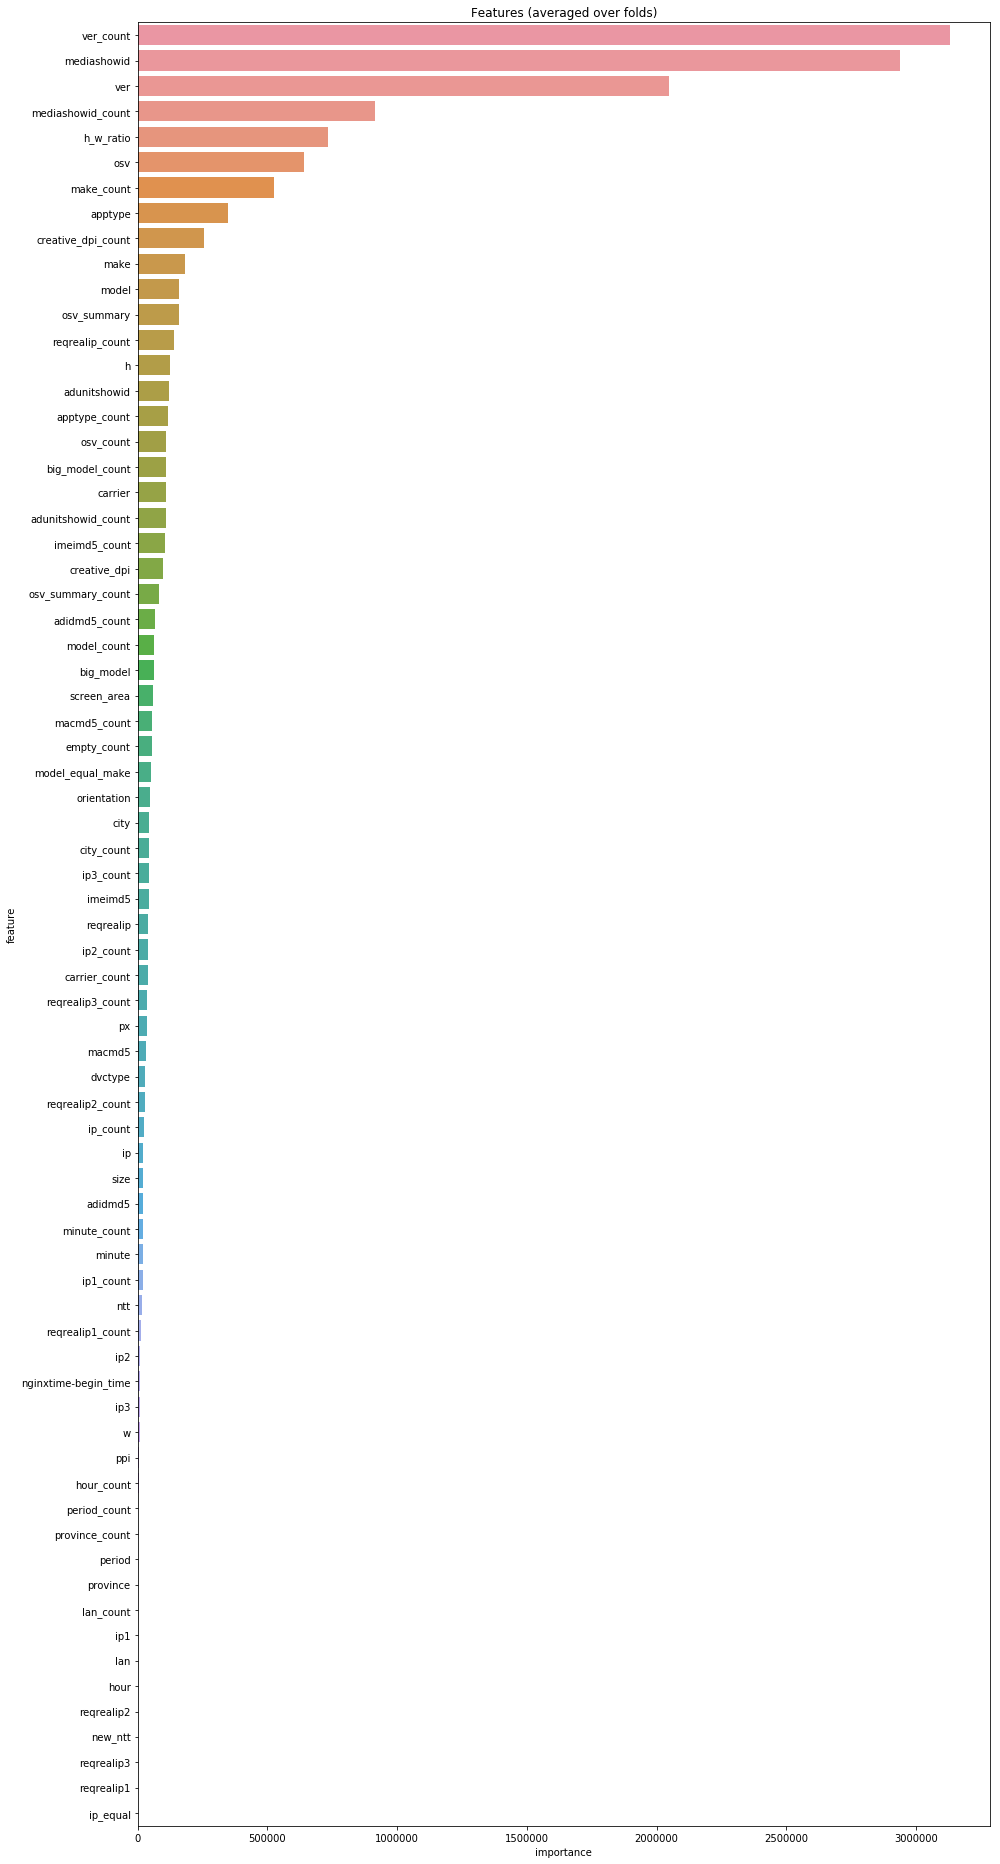

In [9]:
%time train_once(lgb_model,train_x.drop(['sid','label'],axis=1),train_y)

In [15]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(cgb_model)
%time shap_values = explainer.shap_values(train_x[-1000:].drop(['sid','label'],axis=1))

KeyboardInterrupt: 

In [29]:
features = [col for col in train_x.columns if col not in ['sid', 'label']]
shap_values = cgb_model.get_feature_importance(data=cgb.Pool(train_x[-1000:].drop(['sid','label'],axis=1),cat_features=cat_list,feature_names=features),
                       type='ShapValues',
                       prettified=False,
                       thread_count=-1,
                       verbose=True)

Processing trees...
128/1729 trees processed	passed time: 1.77s	remaining time: 22.2s
256/1729 trees processed	passed time: 3.38s	remaining time: 19.5s
384/1729 trees processed	passed time: 5s	remaining time: 17.5s
512/1729 trees processed	passed time: 6.57s	remaining time: 15.6s
640/1729 trees processed	passed time: 8.23s	remaining time: 14s
768/1729 trees processed	passed time: 9.93s	remaining time: 12.4s
896/1729 trees processed	passed time: 11.7s	remaining time: 10.9s
1024/1729 trees processed	passed time: 13.5s	remaining time: 9.3s
1152/1729 trees processed	passed time: 15.4s	remaining time: 7.69s
1280/1729 trees processed	passed time: 17.2s	remaining time: 6.03s
1408/1729 trees processed	passed time: 19.1s	remaining time: 4.35s
1536/1729 trees processed	passed time: 21.1s	remaining time: 2.65s
1664/1729 trees processed	passed time: 23.1s	remaining time: 901ms
1729/1729 trees processed	passed time: 24.1s	remaining time: 0us
Processing documents...
128/1000 documents processed	pass

In [28]:
p = cgb.Pool(train_x[-1000:].drop(['sid','label'],axis=1),cat_features=cat_list)
p.get_features()

array([[ 1.2000000e+01,  8.1908728e-35, -3.4134495e-18, ...,
         6.7112540e+16, -1.0765597e+36,  0.0000000e+00],
       [ 6.0000000e+00,  3.8990505e-34, -5.3608228e+12, ...,
        -8.4958016e+07,  1.0715809e+02,  0.0000000e+00],
       [ 8.0000000e+00,  1.1379730e-38,  8.8996241e+18, ...,
         5.0473328e+14, -5.4867510e-08, -1.0000000e+00],
       ...,
       [ 8.0000000e+00, -5.1273742e-15,  2.0839916e-17, ...,
        -1.4265189e+24,  7.8460383e-21, -1.0000000e+00],
       [ 8.0000000e+00, -5.1273742e-15,  2.7451364e+07, ...,
         9.0658344e+05, -1.0765597e+36,  2.0000000e+00],
       [ 6.0000000e+00, -5.1273742e-15, -1.0630872e+38, ...,
        -5.8732172e-03, -8.3007571e-08, -2.0000000e+00]], dtype=float32)

IndexError: index 71 is out of bounds for axis 1 with size 71

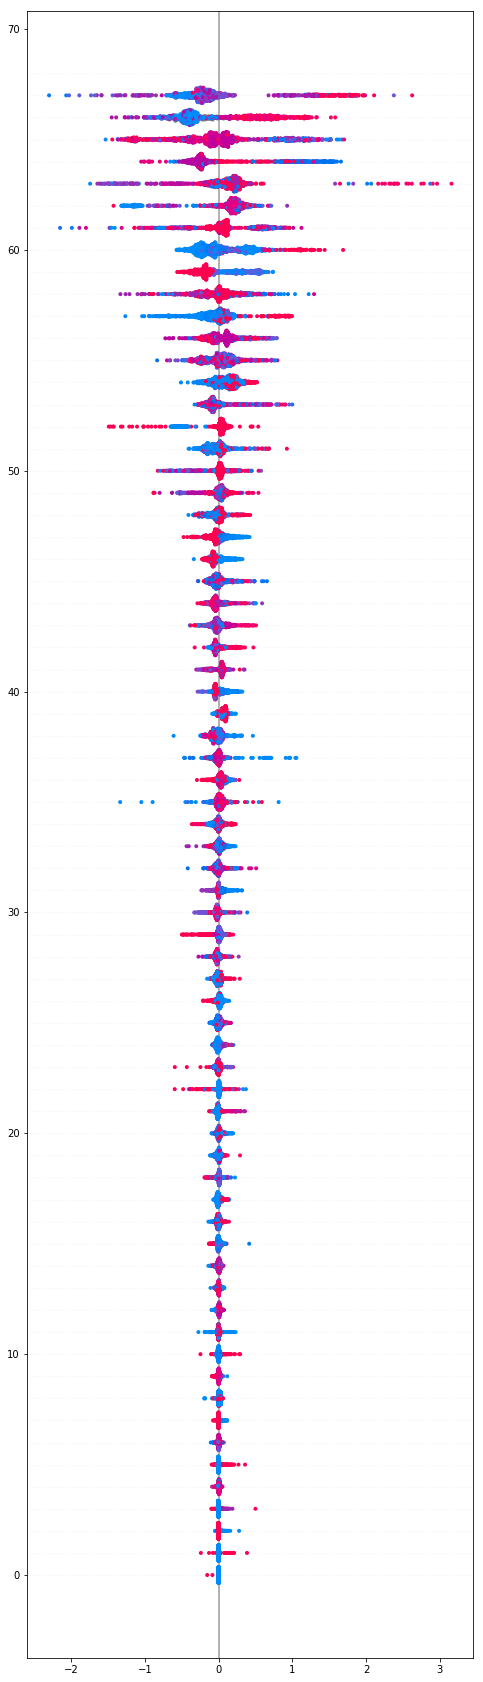

In [30]:
%time shap.summary_plot(shap_values[:,:-1], train_x[-1000:].drop(['sid','label'],axis=1),max_display=100)

In [7]:
result_df = pd.DataFrame() 
result_df['sid'] = test['sid'].tolist()
result_df['label'] = test_pred
result_df['label'] = np.round(result_df['label'])
lct = time.localtime()
result_df.to_csv(submit_path+'submit_{0}-{1}-{2}-{3}-{4}.csv'.format(lct.tm_year,lct.tm_mon,lct.tm_mday,lct.tm_hour,lct.tm_min),index=None)
result_df['label'].value_counts()

1.0    1203675
0.0     796325
Name: label, dtype: int64